# AskReddit Troll Question Detection Challenge

## Imports

In [2]:
import numpy as np 
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

import nltk # for tokenizing the paragraphs in sentences and sentences in words
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/architsangal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/architsangal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/architsangal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
train_df = pd.read_csv("train.csv")

## Preprocessing

### Dropping the qid

In [6]:
train_df.drop(columns=["qid"],inplace=True)
sentences = train_df['question_text'].tolist()

In [7]:
N = 653061
sentences = sentences[0:N]

### Cleaning the data

- Like removing !?., etc.
- converting sentences to lower case

In [8]:
# i=0
# for sentence in sentences:
#     temp = re.sub('[^a-zA-Z0-9]', ' ', sentence)
#     temp = temp.lower()
#     new_sentence = temp.split()
#     new_sentence = ' '.join(new_sentence)
#     sentences[i] = new_sentence
#     # print(new_sentence)
#     i+=1

## Vectoring Words

### Bag Of Words

In [9]:
# TODO max_features = 1500 may need to be altered
cv = CountVectorizer(ngram_range = (1,3))
X1 = cv.fit_transform(sentences)

In [10]:
# print(type(X1))
# print(X1.dtype)
# X1 = X1.astype(float)
# print(X1.dtype)

In [11]:
Y1 = train_df['target'].to_numpy().astype(np.float64)
Y1 = Y1[:N]

### TF IDF

In [12]:
cv = TfidfVectorizer(ngram_range = (1,3))
X2 = cv.fit_transform(sentences)
# print(X2)

In [13]:
print(type(X2))
X2 = X2.astype(float)
print(X2.dtype)

<class 'scipy.sparse.csr.csr_matrix'>
float64


In [14]:
Y2 = Y1

### Train test split data

In [15]:
from sklearn.model_selection import train_test_split 

train_X1, test_X1, train_y1, test_y1 = train_test_split(X1, Y1, train_size=0.6)

train_X2, test_X2, train_y2, test_y2 = train_test_split(X2, Y2, train_size=0.6)

## Model generation

In [16]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### For data genrated by "Bag of words" method  

In [17]:
lreg1 = LogisticRegression(solver='liblinear')
lreg1.fit(train_X1,train_y1)

LogisticRegression(solver='liblinear')

### For data generated by "TD IDF" method

In [18]:
lreg2 = LogisticRegression(solver='liblinear')
lreg2.fit(train_X2,train_y2)

LogisticRegression(solver='liblinear')

### Confusion Matrix

In [19]:
# Compute and plot the Confusion matrix
def confusion_matrix_for_data(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Predict for X1, Y1

In [20]:
train_yhat1 = lreg1.predict_proba(train_X1)
test_yhat1 = lreg1.predict_proba(test_X1)

# print("training score = ", roc_auc_score(train_y1, train_yhat1[:,1]))
# print("test score = ", roc_auc_score(test_y1,test_yhat1[:,1]))

th = threshold = 0.2
temp = max = 0
for i in range(1000):

    train_output1 = (train_yhat1[:,1] > threshold).astype(int)
    test_output1 = (test_yhat1[:,1] > threshold).astype(int)
    threshold += 0.0001
    temp = f1_score(test_y1.astype(int), test_output1)
    if max<temp:
        max = temp
        th = threshold

In [21]:
print(th)
print(max)

0.2001
0.6249624421609277


In [22]:
train_yhat1 = lreg1.predict_proba(train_X1)
test_yhat1 = lreg1.predict_proba(test_X1)

threshold = 0.20139999999999986
train_output1 = (train_yhat1[:,1] > threshold).astype(int)
test_output1 = (test_yhat1[:,1] > threshold).astype(int)

print("training score = ", f1_score(train_y1.astype(int), train_output1))
print("testing score = ", f1_score(test_y1.astype(int), test_output1))

training score =  0.9785109264762367
testing score =  0.6248946671481883


### Predict for X2, Y2

In [23]:
train_yhat2 = lreg2.predict_proba(train_X2)
test_yhat2 = lreg2.predict_proba(test_X2)

th = threshold = 0.2
temp = max = 0
for i in range(2000):

    threshold += 0.0001
    train_output2 = (train_yhat2[:,1] > threshold).astype(int)
    test_output2 = (test_yhat2[:,1] > threshold).astype(int)
    temp = f1_score(test_y2.astype(int), test_output2)
    if max<temp:
        max = temp
        th = threshold
# print("training score = ", roc_auc_score(train_y2, train_yhat2[:,1]))
# print("test score = ", roc_auc_score(test_y2,test_yhat2[:,1]))

In [24]:
print(th)
print(max)

0.20579999999999937
0.5867056245434624


In [25]:
train_yhat2 = lreg2.predict_proba(train_X2)
test_yhat2 = lreg2.predict_proba(test_X2)

threshold = 0.20049999999999996
train_output2 = (train_yhat2[:,1] > threshold).astype(int)
test_output2 = (test_yhat2[:,1] > threshold).astype(int)


print("training score = ", f1_score(train_y2.astype(int), train_output2))
print("testing score = ", f1_score(test_y2.astype(int), test_output2))

training score =  0.7274239763379241
testing score =  0.5857076940823625


### Saving Data

In [26]:
# data = [["question_text","target"]]
# for i in range(N):
#   data.append([sentences[i],Y1[i]])

In [27]:
# import csv

# with open('processed_train_data.csv','w',newline='') as fp:
#   a = csv.writer(fp, delimiter=',')
#   a.writerows(data)

### Confusion Matrix

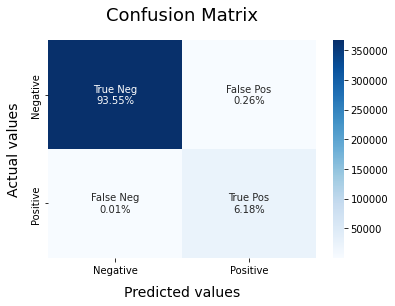

In [28]:
confusion_matrix_for_data(train_y1.astype(int), train_output1)

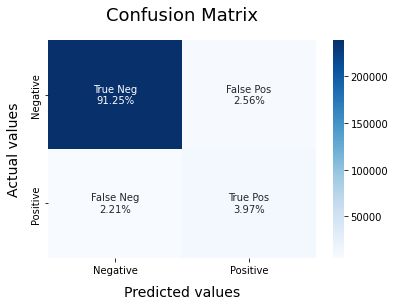

In [29]:
confusion_matrix_for_data(test_y1.astype(int), test_output1)

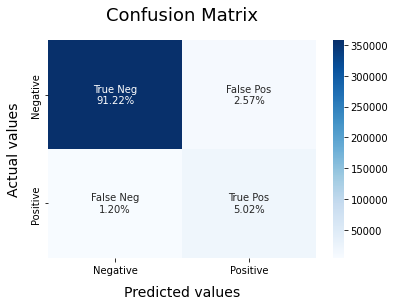

In [30]:
confusion_matrix_for_data(train_y2.astype(int), train_output2)

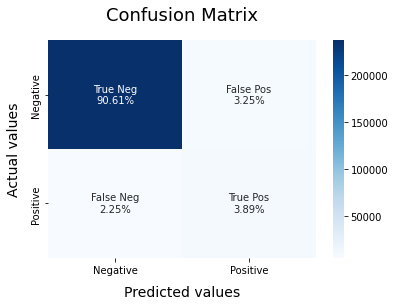

In [31]:
confusion_matrix_for_data(test_y2.astype(int), test_output2)

### Saving Model

In [32]:
# import joblib

# joblib.dump(lreg1,'Using Split LReg1 Model')
# joblib.dump(lreg2,'Using Split LReg2 Model')

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(max_depth=25, random_state=0, criterion="entropy")
clf1.fit(train_X1,train_y1)

RandomForestClassifier(criterion='entropy', max_depth=25, random_state=0)

In [34]:
train_yhat1 = clf1.predict_proba(train_X1)
test_yhat1 = clf1.predict_proba(test_X1)

threshold = 0
max = 0
maxi = 0

for i in range(100):
    threshold += 0.01
    train_output1 = (train_yhat1[:,1] > threshold).astype(int)
    test_output1 = (test_yhat1[:,1] > threshold).astype(int)
    if(f1_score(test_y1, test_output1)>max):
        max = f1_score(test_y1, test_output1)
        maxi = threshold

In [35]:
print("maxi = ", maxi) # best threshold
print("max = ", max)

maxi =  0.07
max =  0.5058527981185525


In [36]:
from sklearn.ensemble import AdaBoostClassifier

clf1 = AdaBoostClassifier(n_estimators=500, random_state=0)
clf1.fit(train_X1,train_y1)

In [ ]:
train_yhat1 = clf1.predict_proba(train_X1)
test_yhat1 = clf1.predict_proba(test_X1)

threshold = 0
max = 0
maxi = 0

for i in range(100):
    threshold += 0.01
    train_output1 = (train_yhat1[:,1] > threshold).astype(int)
    test_output1 = (test_yhat1[:,1] > threshold).astype(int)
    if(f1_score(test_y1, test_output1)>max):
        max = f1_score(test_y1, test_output1)
        maxi = threshold

In [ ]:
print("maxi = ", maxi) # best threshold
print("max = ", max)